In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Predicting NBA 2021-22 MVP**

##      **I. Data preprocessing**

In [91]:
unusefull_columns = [
    'Team',
    'G',             
    'GS',               #Game started, partialy filled
    'FG',               #Sum of 2P and 3P
    'FGA',              #Sum of 2PA and 3PA
    'FG%',              #Depending of 2P% and 3P%
    '2PA',              #Depending of 2P and 2P%
    '3PA',              #Depending of 3P and 3P%
    'FTA',              #Depending of FT and FT%
    'TRB',              #Sum of ORB and DRB
    'Decade',           #Unusefull
    'Trade',            #Filled by False, only players that haven't been
                        #traded during the season can pretend to the award
    'MPTot',            #Depending of number of match during the season
    'W',                #Idem
    'L'                 #Idem
]

In [92]:
#Numeric types of columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'bool']

In [93]:
#Imports
dataset = pd.read_csv('./../data/global.csv').drop(columns=unusefull_columns)

data_22 = pd.read_csv('./../data/2022.csv').drop(columns = [col for col in unusefull_columns if col in pd.read_csv('./../data/2022.csv').columns])

In [94]:
Pos = []
for pos in dataset.Pos.values :
    Pos.append(pos.split("-")[0])

dataset.Pos = Pos

In [95]:
''''Dealing with columns dtypes'''

col_cat = ['Pos', 'Season', 'Player','Tm']

col_int = ['Age', 'GB', 'GBC', 'Ranking_Conf', 'Ranking_League','ShareYN', 'Playoffs', 'MVP','PastMVP']

for column in dataset.columns :
    if column not in col_cat and column not in col_int :
        dataset[column] = dataset[column].astype(float)
    elif column in col_int :
        dataset[column] = dataset[column].astype(int)

### ***1. Scaling of numerical features***

#### **a. Historical seasons dataset**

The aim is to compared each MVP races. So we have to adapt our scaling method and scaled every season regardless from the other. (scaling one season after another)

In [96]:
'''Scaling'''

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

#Float columns
float_columns = ['float16', 'float32', 'float64']

#Columns to scale
columns_scale = list(dataset.select_dtypes(include=float_columns).columns)

#This is the only float column type that we don't want to scale
columns_scale.remove('MVP_share')

def season_scaler(df, season) :
    
    df_season = df[df.Season == season]
    for column in columns_scale :
        data = np.transpose(np.array([df_season[column].values]))
        scaled_data = sc.fit_transform(data)
        df_season[column] = list(scaled_data.transpose()[0])

    return df_season

In [97]:
'''2nd part of scaling'''

pd.options.mode.chained_assignment = None

#Empty dataset that is going to be filled by scaled 'seasons'
dataset_scaled = pd.DataFrame(columns=dataset.columns)

#Looping through seasons
for season in set(dataset.Season.values) :

    #Adding season scaled dataset to global scaled dtaset
    dataset_scaled = dataset_scaled.append(season_scaler(dataset, season), ignore_index=True)

#### **b. 2021-2022 dataset**

In [98]:
data_22_scaled = season_scaler(data_22, '2021-2022')

### ***2. Encoding the column `Pos` (postion played by the player)***

#### **a. Historical seasons dataset**

In [99]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['Pos'])] , remainder='passthrough')

dataset_scaled  = ct.fit_transform(dataset_scaled)

l = ct.get_feature_names_out(input_features=None)

l = [elt.split("__")[1] for elt in l]

In [100]:
dataset_scaled = pd.DataFrame(dataset_scaled)

In [101]:
dic_columns = {}

for col in dataset_scaled.columns :
    dic_columns[col] = l[int(col)]

In [102]:
dataset_scaled.rename(columns = dic_columns, inplace = True)

In [103]:
dataset_scaled.drop(columns = ['Pos_C'], inplace = True)

#### **b. 2021-2022 dataset**

In [104]:
data_22_scaled = ct.fit_transform(data_22_scaled)

l = ct.get_feature_names_out(input_features=None)

l = [elt.split("__")[1] for elt in l]

In [105]:
data_22_scaled = pd.DataFrame(data_22_scaled)

In [106]:
dic_columns = {}

for col in data_22_scaled.columns :
    dic_columns[col] = l[int(col)]

In [107]:
data_22_scaled.rename(columns = dic_columns, inplace = True)

In [108]:
data_22_scaled.drop(columns = ['Pos_C'], inplace = True)

##      **II. Predicting the eligibility**

Our first problem is a classification problem: **Will the player receive votes or not?** (label `ShareYN`)

In [109]:
data_classif = dataset_scaled.drop(columns=['MVP', 'MVP_share'])

#We create a copy of our global dataset without the columns MVP (boolean column) and MVP_share (share of votes that the player received)

### ***1. Dimension dowsizing***

##### **a. Separation between features and labels**

In [110]:
Player_c = data_classif[['Player', 'Season','Tm']]
X_c = data_classif.drop(columns=['Player', 'Season','Tm','ShareYN'])
y_c = data_classif.ShareYN

In [111]:
X_train_c = X_c.sample(frac=0.8).sort_index()
X_test_c = X_c.drop(X_train_c.index).sort_index()

Player_train_c = Player_c.iloc[list(X_train_c.index),:].sort_index()
Player_test_c = Player_c.drop(X_train_c.index).sort_index()

y_train_c = y_c[X_train_c.index].sort_index()
y_test_c = y_c.drop(X_train_c.index).sort_index()

#### **b. Puting the data in the right format**

In [112]:
for col in list(X_train_c.columns)[:5] :
    X_train_c[col] = X_train_c[col].astype(bool)
    X_test_c[col] = X_test_c[col].astype(bool)

In [113]:
y_train_c = y_train_c.astype(bool)
y_test_c = y_test_c.astype(bool)

#### **c. Cross Validation**

##### *1. First naive method*

For our cross validation we choose a Ridge classifier and we have made vary the `alpha` coefficient.

In [114]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

clf_ridge = linear_model.RidgeClassifier()

clf_unblced = GridSearchCV(clf_ridge, {'alpha' : np.array([0.01,1,10])})

clf_unblced.fit(X_train_c.fillna(0), y_train_c)

clf_unblced.cv_results_

{'mean_fit_time': array([0.06221275, 0.06750278, 0.05773029]),
 'std_fit_time': array([0.00184591, 0.00303551, 0.00306052]),
 'mean_score_time': array([0.01613936, 0.01850696, 0.0167161 ]),
 'std_score_time': array([0.00196573, 0.0025292 , 0.00214652]),
 'param_alpha': masked_array(data=[0.01, 1.0, 10.0],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01}, {'alpha': 1.0}, {'alpha': 10.0}],
 'split0_test_score': array([0.97501983, 0.97541634, 0.97541634]),
 'split1_test_score': array([0.97383029, 0.97462331, 0.97462331]),
 'split2_test_score': array([0.97105472, 0.97105472, 0.97105472]),
 'split3_test_score': array([0.97105472, 0.97065821, 0.9702617 ]),
 'split4_test_score': array([0.97383029, 0.97383029, 0.97343378]),
 'mean_test_score': array([0.97295797, 0.97311657, 0.97295797]),
 'std_test_score': array([0.00161356, 0.00191642, 0.00199678]),
 'rank_test_score': array([2, 1, 2], dtype=int32)}

We see that whatever the value of the alpha parameter, our predictor obtains the same score.

In [115]:
y_train_c.value_counts()

False    12069
True       541
Name: ShareYN, dtype: int64

After this test we see that our dataset is unbalanced. Indeed there is a ratio higher than 20 between the two labels. So we have to balance our dataset.

##### *2. Dealing with unbalanced dataset*

To tackle the unbalanced dataset issue, we will use an oversampling method.

In [116]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy ='minority')

In [117]:
X_over_c, y_over_c = oversample.fit_resample(X_train_c, y_train_c)

In [118]:
from sklearn.metrics import make_scorer, recall_score

scoring = True

scorer_c = make_scorer(recall_score)

if scoring :
    clf_over = GridSearchCV(clf_ridge, {'alpha' : np.array([0.01,1,10])}, scoring=scorer_c)
else :
    clf_over = GridSearchCV(clf_ridge, {'alpha' : np.array([0.01,1,10])})

clf_over.fit(X_over_c.fillna(0), y_over_c)

clf_over.cv_results_

{'mean_fit_time': array([0.12651548, 0.13075762, 0.11444583]),
 'std_fit_time': array([0.02641129, 0.02956984, 0.00730953]),
 'mean_score_time': array([0.02412839, 0.02844453, 0.02524586]),
 'std_score_time': array([0.00292727, 0.00583905, 0.00476915]),
 'param_alpha': masked_array(data=[0.01, 1.0, 10.0],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01}, {'alpha': 1.0}, {'alpha': 10.0}],
 'split0_test_score': array([0.95898923, 0.95898923, 0.96188898]),
 'split1_test_score': array([0.95608948, 0.95608948, 0.95691798]),
 'split2_test_score': array([0.95443248, 0.95443248, 0.95733223]),
 'split3_test_score': array([0.95980108, 0.95980108, 0.95980108]),
 'split4_test_score': array([0.95608948, 0.95608948, 0.95608948]),
 'mean_test_score': array([0.95708035, 0.95708035, 0.95840595]),
 'std_test_score': array([0.00200105, 0.00200105, 0.00213592]),
 'rank_test_score': array([2, 2, 1], dtype=int32)}

In [119]:
clf_over.best_estimator_

RidgeClassifier(alpha=10.0)

#### **d. Extract important features**

After this CV, we extract the coefficients of the most important features.

In [120]:
features_coefs = np.transpose(np.vstack((X_over_c.columns, np.abs(clf_over.best_estimator_.coef_))))

features_coefs = pd.DataFrame(features_coefs, columns = ['feature', 'coef']).sort_values('coef', ascending = False, ignore_index = True)

<AxesSubplot:xlabel='coef', ylabel='feature'>

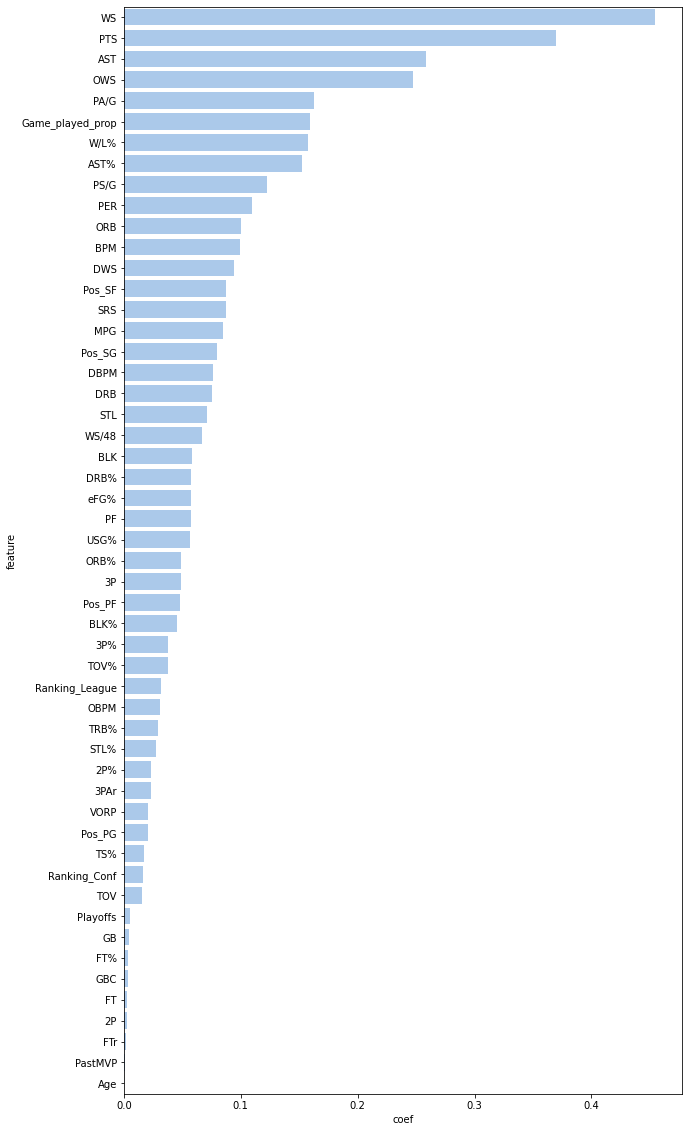

In [121]:
plt.figure(figsize = (10,20))

sns.set_color_codes("pastel")
sns.barplot(y=features_coefs.feature, x=features_coefs.coef, color="b")


In this histogram we have the features having the most impact on the prediction. We decide to take only the 15 most important ones.

In [122]:
features = features_coefs.feature.values[:15]

In [123]:
features

array(['WS', 'PTS', 'AST', 'OWS', 'PA/G', 'Game_played_prop', 'W/L%',
       'AST%', 'PS/G', 'PER', 'ORB', 'BPM', 'DWS', 'Pos_SF', 'SRS'],
      dtype=object)

### ***2. Machine learning model for our classification***

Let's get back our balanced training datasets.

Our features are given by this list :

In [124]:
features

array(['WS', 'PTS', 'AST', 'OWS', 'PA/G', 'Game_played_prop', 'W/L%',
       'AST%', 'PS/G', 'PER', 'ORB', 'BPM', 'DWS', 'Pos_SF', 'SRS'],
      dtype=object)

Let's make our balanced train reduced to our selected features features.

In [125]:
X_train_classifier = X_over_c[features].fillna(0)
y_train_classifier = y_over_c

We will make our classification with a `RidgeClassifier`. (alpha = 10)

#### **a. Training and performances of the model**

In [126]:
classifier = linear_model.RidgeClassifier(alpha=10)

In [127]:
y_train_classifier

0        False
1        False
2        False
3        False
4        False
         ...  
24133     True
24134     True
24135     True
24136     True
24137     True
Name: ShareYN, Length: 24138, dtype: bool

In [128]:
X_train_classifier

,WS,PTS,AST,OWS,PA/G,Game_played_prop,W/L%,AST%,PS/G,PER,ORB,BPM,DWS,Pos_SF,SRS
0,-0.103143,-0.592278,-0.753183,0.159209,1.730763,0.135037,-0.573658,-0.913376,1.056080,0.214957,0.248370,0.274406,-0.540061,False,-0.466151
1,-1.048793,-0.885843,-0.586360,-1.010992,1.730763,-0.195096,-0.573658,-0.551056,1.056080,-1.425978,-0.760502,-0.981322,-0.795123,False,-0.466151
2,-0.778607,0.271148,0.025324,-0.620925,1.730763,0.506436,-0.573658,-0.177758,1.056080,-0.784693,-1.012720,-0.781547,-0.880144,False,-0.466151
3,-0.846154,-0.851306,-0.697575,-0.669683,1.730763,-1.598162,-0.573658,-0.485180,1.056080,-0.426328,-0.760502,-0.210762,-1.050186,True,-0.466151
4,0.268362,0.547445,-0.252714,0.305484,1.730763,0.547703,-0.573658,-0.573015,1.056080,0.064067,-0.129957,0.331484,0.140105,False,-0.466151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24133,2.779600,2.536071,1.697629,2.163222,-0.359655,0.963347,0.702510,0.850581,0.266673,1.927561,1.961195,1.811098,3.237513,False,0.593762
24134,3.376070,2.222157,-0.060260,2.448801,-0.900383,0.885866,1.101225,-0.459058,-0.142879,2.475429,2.709265,2.010979,4.238530,False,0.795745
24135,2.843602,3.016817,1.097130,3.582426,-0.043700,1.002317,0.319110,0.746861,-0.064684,1.892365,0.807055,1.631490,1.011116,True,-0.093750
24136,1.626275,2.013939,0.304267,1.627579,-0.204651,0.765886,1.048641,-0.368741,0.696091,0.943642,0.464925,0.542822,1.055116,True,0.816922


In [129]:
classifier.fit(X_train_classifier, y_train_classifier)

RidgeClassifier(alpha=10)

In [130]:
classifier.score(X_test_c[features].fillna(0), y_test_c)

0.9213447510307643

In [131]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_c,classifier.predict(X_test_c[features].fillna(0)))

array([[2770,  245],
       [   3,  135]])

In [132]:
y_test_c.value_counts()

False    3015
True      138
Name: ShareYN, dtype: int64

#### **b. Extraction of our 2021-2022 canditates**

##### *1. Splitting dataset*

In [133]:
Player_22 = data_22_scaled[['Player']]

X_22_classif = data_22_scaled.drop(columns=['Player', 'Season','Tm'])

In [134]:
X_22_classif = pd.DataFrame(X_22_classif)

In [135]:
for col in list(X_22_classif.columns)[:5] :
    X_22_classif[col] = X_22_classif[col].astype(bool)

In [136]:
X_22_classif = X_22_classif[features].fillna(0)

##### *2. Prediction of our candidates*

In [137]:
y_pred_22 = classifier.predict(X_22_classif)

In [138]:
results_22 = Player_22.assign(Prediction = y_pred_22)

results_22['coefs'] = classifier.decision_function(X_22_classif)


In [139]:
results_22[results_22.Prediction].sort_values('coefs', ascending = False, ignore_index = True)

,Player,Prediction,coefs
0,Nikola Jokić,True,1.353364
1,Giannis Antetokounmpo,True,1.225088
2,Joel Embiid,True,1.191589
3,Chris Paul,True,1.129898
4,Luka Dončić,True,1.065264
...,...,...,...
60,Bobby Portis,True,0.054040
61,Steven Adams,True,0.050267
62,OG Anunoby,True,0.047128
63,Dillon Brooks,True,0.034511


In [140]:
candidates = results_22.sort_values('coefs',ascending = False).Player.values[:20]

In [141]:
candidates

array(['Nikola Jokić', 'Giannis Antetokounmpo', 'Joel Embiid',
       'Chris Paul', 'Luka Dončić', 'Stephen Curry', 'Ja Morant',
       'James Harden', 'LeBron James', 'Jimmy Butler', 'Devin Booker',
       'Kevin Durant', 'DeMar DeRozan', 'Jayson Tatum',
       'Karl-Anthony Towns', 'Dejounte Murray', 'Trae Young',
       'Donovan Mitchell', 'Fred VanVleet', 'Rudy Gobert'], dtype=object)

##      **III. Predicting the 2021-2022 NBA MVP**

Our second and last problem is a regression problem: **How many votes the player will receive?** (label `MVP_share`)

In [142]:
data_reg = dataset_scaled[dataset_scaled.ShareYN == 1].drop(columns=['MVP', 'ShareYN']).reset_index()

#We create a copy of our global dataset (only with players that received votes)
#without the columns MVP and ShareYN (0/1 columns)

###      ***1. Creating 2021-2022 dataset with candidates***

In [143]:
data_22_reg = data_22_scaled[data_22_scaled.Player.isin(candidates)]

data_22_reg = data_22_reg.reset_index()

In [144]:
Player_22_reg = data_22_reg[['Player']]

X_22_reg = data_22_reg[features]

###      ***2. Splitting, formating***

#### **a. Splitting**

In [145]:
Player_reg = data_reg[['Player', 'Season','Tm']]
X_reg = data_reg.drop(columns=['Player', 'Season','Tm','MVP_share'])
y_reg = data_reg.MVP_share

In [146]:
X_train_reg = X_reg.sample(frac=0.8).sort_index()
X_test_reg = X_reg.drop(X_train_reg.index).sort_index()

Player_train_reg = Player_reg.iloc[list(X_train_reg.index),:].sort_index()
Player_test_reg = Player_reg.drop(X_train_reg.index).sort_index()

y_train_reg = y_reg[X_train_reg.index].sort_index()
y_test_reg = y_reg.drop(X_train_reg.index).sort_index()

#### **b. Puting the data in the right format**

In [147]:
X_train_reg = pd.DataFrame(X_train_reg)
X_test_reg = pd.DataFrame(X_test_reg)

In [148]:
y_train_reg = y_train_reg.astype(float)
y_test_reg = y_test_reg.astype(float)

###      ***3. Dimension downsizing***

We will use the same features that we used to determine the candidates, these are stocked in the `features`.

In [149]:
X_train_reg = X_train_reg[features].fillna(0)
X_test_reg = X_test_reg[features].fillna(0)

###      ***4. Machine learning models for our regression***

To predict the MVP award winner, we will use differents algorithms and synthesize them in the report. Thus we will use :
- Linear regression
- Random Forest
- kNN
- Deep Neural Networks

#### **a. Linear regression**

##### *1. Training and performances*

In [150]:
from sklearn.linear_model import LinearRegression

reg_lin = LinearRegression()

reg_lin.fit(X_train_reg, y_train_reg)

LinearRegression()

In [151]:
reg_lin.score(X_test_reg, y_test_reg)

0.5392054680268724

##### *2. Prediction for 2021-2022 season*

In [152]:
y_pred_22_lin = reg_lin.predict(X_22_reg)

In [153]:
results_22_lin = pd.DataFrame(np.vstack((Player_22_reg.to_numpy().transpose(), y_pred_22_lin)).transpose(), columns = ['player', 'share_pred'])

In [154]:
results_22_lin.sort_values('share_pred', ascending = False).reset_index()

,index,player,share_pred
0,13,Nikola Jokić,0.471156
1,5,Giannis Antetokounmpo,0.422249
2,14,Joel Embiid,0.388486
3,8,Chris Paul,0.312992
4,17,Stephen Curry,0.311721
5,1,Ja Morant,0.244819
6,7,Devin Booker,0.243149
7,11,DeMar DeRozan,0.240279
8,2,Jimmy Butler,0.230671
9,19,Luka Dončić,0.229363


#### **b. Random Forest**

##### *1. Training and performances*

In [155]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

reg_rf = RandomForestRegressor()

param_rf = {
                'max_depth' : np.array([5, 10, 15]),
            }

reg_rf_CV = GridSearchCV(reg_rf, param_rf)

reg_rf_CV.fit(X_train_reg, y_train_reg)

reg_rf_CV.cv_results_

{'mean_fit_time': array([0.21668506, 0.26510262, 0.31693187]),
 'std_fit_time': array([0.03678972, 0.0022815 , 0.01182043]),
 'mean_score_time': array([0.00804019, 0.00805464, 0.00880699]),
 'std_score_time': array([0.00066261, 0.00041383, 0.00083787]),
 'param_max_depth': masked_array(data=[5, 10, 15],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5}, {'max_depth': 10}, {'max_depth': 15}],
 'split0_test_score': array([0.57249439, 0.58098811, 0.56564264]),
 'split1_test_score': array([0.52793917, 0.52526225, 0.52040273]),
 'split2_test_score': array([0.62453921, 0.598329  , 0.61656465]),
 'split3_test_score': array([0.52431773, 0.53861482, 0.54179902]),
 'split4_test_score': array([0.57046421, 0.57185786, 0.58574243]),
 'mean_test_score': array([0.56395094, 0.56301041, 0.5660303 ]),
 'std_test_score': array([0.0364801 , 0.02708855, 0.03350065]),
 'rank_test_score': array([2, 3, 1], dtype=int32)}

In [156]:
reg_rf_best = reg_rf_CV.best_estimator_

reg_rf_best.score(X_test_reg, y_test_reg)

0.7266402891757502

##### *2. Prediction for 2021-2022 season*

In [157]:
y_pred_22_rf = reg_rf_best.predict(X_22_reg)

In [158]:
results_22_rf = pd.DataFrame(np.vstack((Player_22_reg.to_numpy().transpose(), y_pred_22_rf)).transpose(), columns = ['player', 'share_pred'])

In [159]:
results_22_rf.sort_values('share_pred', ascending = False).reset_index()

,index,player,share_pred
0,8,Chris Paul,0.46407
1,13,Nikola Jokić,0.41442
2,5,Giannis Antetokounmpo,0.40183
3,14,Joel Embiid,0.35278
4,17,Stephen Curry,0.276354
5,18,Jayson Tatum,0.235747
6,9,Rudy Gobert,0.23316
7,6,LeBron James,0.132205
8,12,Trae Young,0.120841
9,11,DeMar DeRozan,0.111104


#### **c. kNN**

##### *1. Training and performances*

In [160]:
from sklearn.neighbors import KNeighborsRegressor

reg_kNN = KNeighborsRegressor()

param_kNN = {
                'n_neighbors' : np.array([5, 10, 15, 20, 25]),
            }

reg_kNN_CV = GridSearchCV(reg_kNN, param_kNN)

reg_kNN_CV.fit(X_train_reg, y_train_reg)

reg_kNN_CV.cv_results_

{'mean_fit_time': array([0.0019094 , 0.00151882, 0.0014616 , 0.00167141, 0.00160465]),
 'std_fit_time': array([5.46410207e-04, 1.46859234e-04, 6.79944708e-05, 3.17851137e-04,
        2.59806011e-04]),
 'mean_score_time': array([0.00244718, 0.00256562, 0.0025651 , 0.0026032 , 0.002741  ]),
 'std_score_time': array([0.00032984, 0.00040471, 0.00024945, 0.00025781, 0.00043652]),
 'param_n_neighbors': masked_array(data=[5, 10, 15, 20, 25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 5},
  {'n_neighbors': 10},
  {'n_neighbors': 15},
  {'n_neighbors': 20},
  {'n_neighbors': 25}],
 'split0_test_score': array([0.56908011, 0.49773332, 0.46586461, 0.46982158, 0.44276721]),
 'split1_test_score': array([0.48863241, 0.43663575, 0.47790827, 0.47697713, 0.47746744]),
 'split2_test_score': array([0.58608501, 0.59338538, 0.6051257 , 0.59102939, 0.58348381]),
 'split3_test_score': array([0.53422154, 0.49931706, 0.

In [161]:
reg_kNN_best = reg_kNN_CV.best_estimator_

reg_kNN_best.score(X_test_reg, y_test_reg)

0.6322285053947526

##### *2. Prediction for 2021-2022 season*

In [162]:
y_pred_22_kNN = reg_kNN_best.predict(X_22_reg)

In [163]:
results_22_kNN = pd.DataFrame(np.vstack((Player_22_reg.to_numpy().transpose(), y_pred_22_kNN)).transpose(), columns = ['player', 'share_pred'])

In [164]:
results_22_kNN.sort_values('share_pred', ascending = False).reset_index()

,index,player,share_pred
0,5,Giannis Antetokounmpo,0.4554
1,13,Nikola Jokić,0.4142
2,8,Chris Paul,0.3368
3,17,Stephen Curry,0.222
4,9,Rudy Gobert,0.2058
5,10,Donovan Mitchell,0.1398
6,14,Joel Embiid,0.1326
7,11,DeMar DeRozan,0.1098
8,6,LeBron James,0.1092
9,7,Devin Booker,0.1028


#### **d. Deep Neural Network**

##### *1. Training and performances*

In [165]:
from sklearn.neural_network import MLPRegressor

reg_DNN = MLPRegressor()

param_DNN = {
                'hidden_layer_sizes' : np.array([50, 100, 200]),
                'activation' : np.array(['relu', 'logistic'])
            }

reg_DNN_CV = GridSearchCV(reg_DNN, param_DNN)

reg_DNN_CV.fit(X_train_reg, y_train_reg)

reg_DNN_CV.cv_results_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'mean_fit_time': array([0.18668866, 0.23550262, 0.30830817, 0.12244186, 0.08749719,
        0.16581197]),
 'std_fit_time': array([0.03647668, 0.06943431, 0.11903702, 0.05106212, 0.01392922,
        0.07491099]),
 'mean_score_time': array([0.00159202, 0.00214415, 0.001548  , 0.00212555, 0.00162277,
        0.00229225]),
 'std_score_time': array([3.41619552e-04, 9.89291346e-04, 3.84084561e-05, 3.36826894e-04,
        4.85797615e-05, 7.55840995e-04]),
 'param_activation': masked_array(data=['relu', 'relu', 'relu', 'logistic', 'logistic',
                    'logistic'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[50, 100, 200, 50, 100, 200],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'activation': 'relu', 'hidden_layer_sizes': 50},
  {'activation': 'relu', 'hidden_layer_sizes': 100},
  {

In [166]:
reg_DNN_best = reg_DNN_CV.best_estimator_

reg_DNN_best.score(X_test_reg, y_test_reg)

0.730148046632838

##### *2. Prediction for 2021-2022 season*

In [167]:
y_pred_22_DNN = reg_DNN_best.predict(X_22_reg)

In [168]:
results_22_DNN = pd.DataFrame(np.vstack((Player_22_reg.to_numpy().transpose(), y_pred_22_DNN)).transpose(), columns = ['player', 'share_pred'])

In [169]:
results_22_DNN.sort_values('share_pred', ascending = False)

,player,share_pred
5,Giannis Antetokounmpo,0.541975
13,Nikola Jokić,0.469577
14,Joel Embiid,0.430838
17,Stephen Curry,0.294787
8,Chris Paul,0.254633
11,DeMar DeRozan,0.252655
9,Rudy Gobert,0.188266
2,Jimmy Butler,0.17094
1,Ja Morant,0.159496
6,LeBron James,0.155334


##### *3. Bonus : Accuracy through history*

Dowsizing the number of features

In [170]:
dataset_bonus = dataset_scaled[dataset_scaled.ShareYN == 1]

In [171]:
seasons = list(set(dataset_bonus.Season.values))

seasons.sort()

Player_reg_bonus = dataset_bonus[['Player', 'Season']].reset_index()
X_reg_bonus = dataset_bonus.drop(columns=['Player', 'Season','Tm','MVP_share']).reset_index()
y_reg_bonus = dataset_bonus.MVP_share.reset_index()

L=[]
for season in seasons :
    l=[]
    l.append(season)
    l.append(dataset[(dataset.Season == season)&(dataset.MVP == 1)].Player.values[0])

    Player_test = Player_reg_bonus[Player_reg_bonus.Season == season]
    
    X_test = X_reg_bonus.iloc[list(Player_test.index),:].sort_index()
    y_test = y_reg_bonus.iloc[list(Player_test.index),:].sort_index()

    Player_train = Player_reg_bonus.drop(Player_test.index).sort_index()
    X_train = X_reg_bonus.drop(Player_test.index).sort_index()
    y_train = y_reg_bonus.drop(Player_test.index).sort_index()

    reg_lin.fit(X_train[features].fillna(0), y_train['MVP_share'])
    reg_kNN_best.fit(X_train[features].fillna(0), y_train['MVP_share'])
    reg_rf_best.fit(X_train[features].fillna(0), y_train['MVP_share'])
    reg_DNN_best.fit(X_train[features].fillna(0), y_train['MVP_share'])

    y_pred_lin = reg_lin.predict(X_test[features].fillna(0))
    y_pred_rf = reg_rf_best.predict(X_test[features].fillna(0))
    y_pred_kNN = reg_kNN_best.predict(X_test[features].fillna(0))
    y_pred_DNN = reg_kNN_best.predict(X_test[features].fillna(0))

    results = [list(Player_test.Player.values),list(y_pred_lin),list(y_pred_kNN), list(y_pred_rf), list(y_pred_DNN)]

    results = np.array(results)

    results = pd.DataFrame(results.transpose(), columns = ['player', 'share_pred_lin', 'share_pred_kNN', 'share_pred_rf', 'share_pred_DNN'])


    l.append(results[results.share_pred_lin == max(list(results.share_pred_lin.values))].player.values[0])
    l.append(results[results.share_pred_kNN == max(list(results.share_pred_kNN.values))].player.values[0])
    l.append(results[results.share_pred_rf == max(list(results.share_pred_rf.values))].player.values[0])
    l.append(results[results.share_pred_DNN == max(list(results.share_pred_DNN.values))].player.values[0])
    L.append(l)

predictions = pd.DataFrame(L, columns = ['Season', 'Actual MVP', 'Predicted MVP Lin Reg', 'Predicted MVP kNN', 'Predicted MVP RandFor', 'Predicted MVP DNN'])

In [172]:
predictions

,Season,Actual MVP,Predicted MVP Lin Reg,Predicted MVP kNN,Predicted MVP RandFor,Predicted MVP DNN
0,1979-1980,Kareem Abdul-Jabbar,Dennis Johnson,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar
1,1980-1981,Julius Erving,Julius Erving,Julius Erving,Julius Erving,Julius Erving
2,1981-1982,Moses Malone,Moses Malone,Julius Erving,Julius Erving,Julius Erving
3,1982-1983,Moses Malone,Moses Malone,Moses Malone,Moses Malone,Moses Malone
4,1983-1984,Larry Bird,Larry Bird,Larry Bird,Larry Bird,Larry Bird
5,1984-1985,Larry Bird,Larry Bird,Larry Bird,Larry Bird,Larry Bird
6,1985-1986,Larry Bird,Larry Bird,Larry Bird,Larry Bird,Larry Bird
7,1986-1987,Magic Johnson,Magic Johnson,Larry Bird,Magic Johnson,Larry Bird
8,1987-1988,Michael Jordan,Michael Jordan,Michael Jordan,Michael Jordan,Michael Jordan
9,1988-1989,Magic Johnson,Michael Jordan,Michael Jordan,Michael Jordan,Michael Jordan


In [173]:
predictions.to_excel('./../academic/predictions.xlsx', index=False)

In [174]:
predictions['ok_lin'] = predictions['Actual MVP'] == predictions['Predicted MVP Lin Reg']
predictions['ok_kNN'] = predictions['Actual MVP'] == predictions['Predicted MVP kNN']
predictions['ok_rf'] = predictions['Actual MVP'] == predictions['Predicted MVP RandFor']
predictions['ok_DNN'] = predictions['Actual MVP'] == predictions['Predicted MVP DNN']

In [175]:
print(f'Accuracy of Linear Model through years  : {sum(predictions.ok_lin.values)/len(predictions)}')
print(f'Accuracy of kNN Model through years  : {sum(predictions.ok_kNN.values)/len(predictions)}')
print(f'Accuracy of Random Forest Model through years  : {sum(predictions.ok_rf.values)/len(predictions)}')
print(f'Accuracy of DNN Model through years  : {sum(predictions.ok_DNN.values)/len(predictions)}')

Accuracy of Linear Model through years  : 0.6666666666666666
Accuracy of kNN Model through years  : 0.6428571428571429
Accuracy of Random Forest Model through years  : 0.7142857142857143
Accuracy of DNN Model through years  : 0.6428571428571429
